In [1]:
import tensorflow as tf
import urllib
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
import os
train_bears_dir = os.path.join('temp/PandasBears/Train/Bears')
train_pandas_dir = os.path.join('temp/PandasBears/Train/Pandas')
Test_bears_dir = os.path.join('temp/PandasBears/Test/Bears')
Test_pandas_dir = os.path.join('temp/PandasBears/Test/Pandas')

train_bears_names = os.listdir(train_bears_dir)
train_pandas_names = os.listdir(train_pandas_dir)
Test_bears_names = os.listdir(Test_bears_dir)
Test_pandas_names = os.listdir(Test_pandas_dir)

In [3]:
# 사전 훈련된 가중치 불러오기
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weight_file = r'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top = False,
                                weights = None)
pre_trained_model.load_weights(local_weight_file)

# 사전 훈련 계층의 가중치의 훈련 가능 여부를 설정 : False(학습안함)
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print("last shape: ", last_layer.output_shape) # (None, 7, 7, 768)
last_output = last_layer.output

last shape:  (None, 7, 7, 768)


In [4]:
# 모델 구성 / 컴파일
# Flatten layer
x = layers.Flatten()(last_output) # (None, 37632)
# Dense Layer : Hidden Layer
x = layers.Dense(1024,activation='relu')(x)
# Dropout Layer : 0.2
x = layers.Dropout(0.2)(x)
#Dense Layer : Final Output Layer, sigmoid
x = layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input,x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [5]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [6]:
train_dir = 'temp/PandasBears/Train'
val_dir = 'temp/PandasBears/Test'

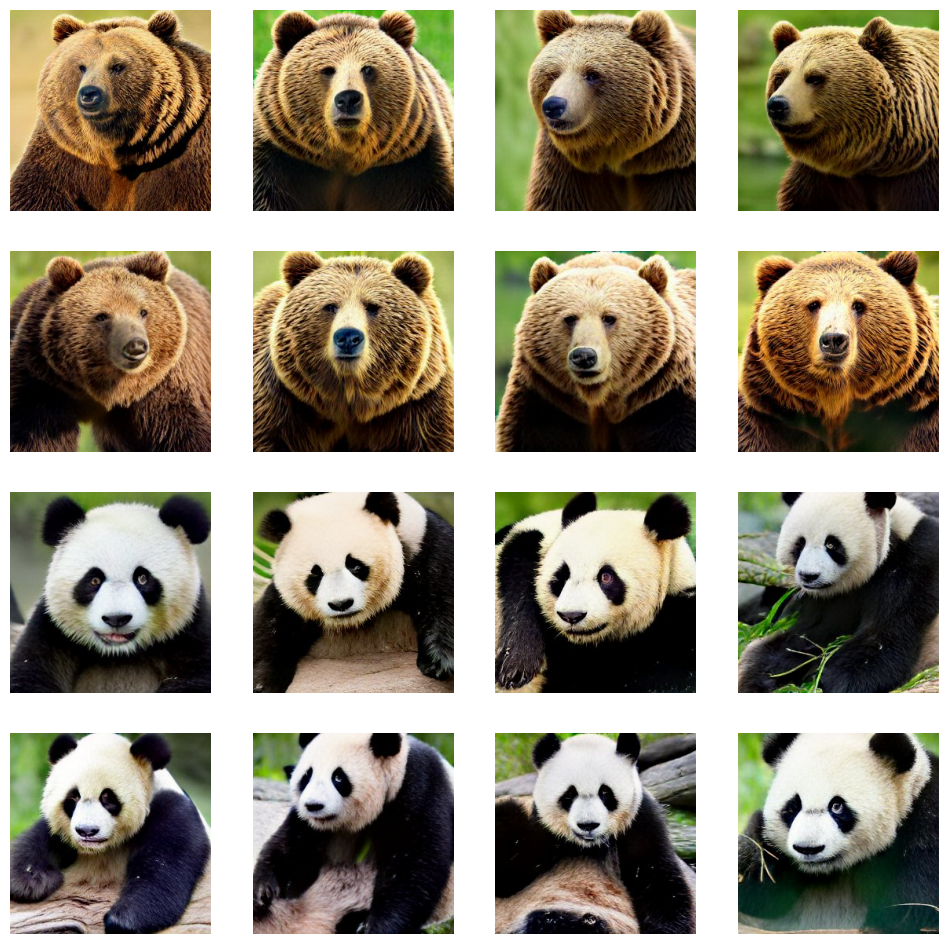

In [11]:
# 데이터 시각화
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images ,시작 인덱스

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index+=8

next_bears_pix = [os.path.join(train_bears_dir, fname) 
                for fname in train_bears_names[ pic_index-8:pic_index] 
               ]

next_pandas_pix = [os.path.join(train_pandas_dir, fname) 
                for fname in train_pandas_names[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_bears_pix+next_pandas_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,                                   
                                  )
validation_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,                    
                                                    batch_size=20,
                                                    class_mode = 'binary',
                                                    target_size = (150,150))

validation_generator = validation_datagen.flow_from_directory(val_dir,                                                              
                                                              batch_size=20,
                                                              class_mode = 'binary',
                                                              target_size = (150,150))

Found 500 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [8]:
# 학습
# fit 호출시 1 epoch 마다 train 이미지 2000개 생성 
# fit 호출시 1 epoch 마다 validation 이미지 1000개 생성 
history = model.fit(train_generator, # X
          steps_per_epoch=25,  # 500/20
          epochs=20,
          validation_data=validation_generator,
          validation_steps=5, # 100/20
          verbose=1)

Epoch 1/20
25/25 [==============================] - 5s 69ms/step - loss: 1.7034 - accuracy: 0.9360 - val_loss: 3.7931e-30 - val_accuracy: 1.0000
Epoch 2/20
25/25 [==============================] - 1s 50ms/step - loss: 9.0583e-17 - accuracy: 1.0000 - val_loss: 3.7931e-30 - val_accuracy: 1.0000
Epoch 3/20
25/25 [==============================] - 1s 50ms/step - loss: 2.1747e-08 - accuracy: 1.0000 - val_loss: 3.7477e-30 - val_accuracy: 1.0000
Epoch 4/20
25/25 [==============================] - 1s 50ms/step - loss: 0.0795 - accuracy: 0.9940 - val_loss: 2.1508e-22 - val_accuracy: 1.0000
Epoch 5/20
25/25 [==============================] - 1s 50ms/step - loss: 0.0127 - accuracy: 0.9980 - val_loss: 1.4521e-17 - val_accuracy: 1.0000
Epoch 6/20
25/25 [==============================] - 1s 50ms/step - loss: 2.8639e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/20
25/25 [==============================] - 1s 50ms/step - loss: 2.7632e-21 - accuracy: 1.0000 - val_loss: 0.0

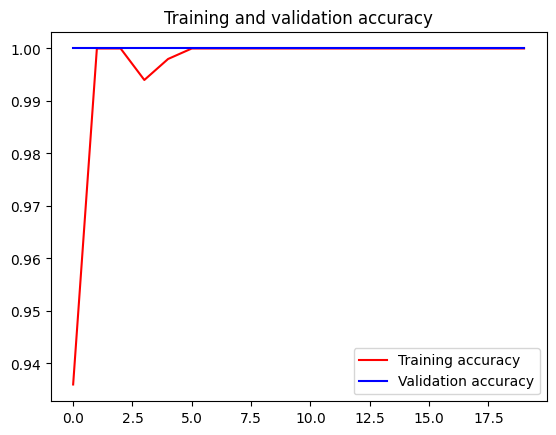

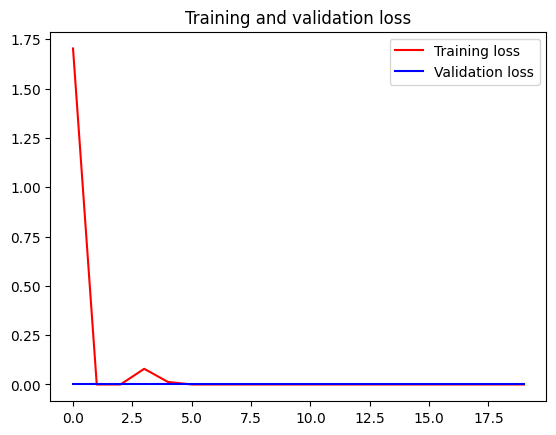

In [9]:
# 학습 결과 시각화 (옵션)
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()